In [1]:
import json

import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
from scipy.optimize import minimize

from matplotlib import pyplot as plt, scale as mscale, colors, cm
import cmasher

from tqdm import tqdm

EPSILON = np.finfo(float).eps

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}')
plt.rcParams['figure.figsize'] = [6, 2.2]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 9.5
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.2
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.edgecolor'] = '#333'
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.9
plt.rcParams['patch.linewidth'] = 0.9
plt.rcParams['hatch.linewidth'] = 0.9
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['xtick.minor.width'] = 0.6
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
R_P = np.linspace(0, 0.5, 200)

def get_R_Q(mu, kappa_gamma):
    Z = kappa_gamma * mu * np.tan(np.pi * R_P) ** 2 + mu
    return np.arccos(1 / np.sqrt(Z)) / np.pi

In [4]:
with open('stats_experiment_mnist_to_ardis_binary_v1_s1009.json', 'r') as f:
    stats = json.load(f)

dataset_ids = ["mnist", "ardis"]
model_ids = [ 
    "alexnet",
    "vgg11",
    "vgg16",
    "resnet18",
    "resnet50",
    "densenet121",
    "densenet161",
]
metric_ids = ["loss", "accuracy"]

# {"accuracy": {"mnist": [[],], "ardis": [[],]}, 
#      "loss": {"mnist": [[],], "ardis": [[],]}, 
# "model_ids": []}
data = dict() 
model_ids_including_ckpt = []
for metric_id in metric_ids:
    data[metric_id] = dict()
    for dataset_id in dataset_ids:
        data[metric_id][dataset_id] = [] 
        for model_id in model_ids:
            metric = []
            for run in stats[dataset_id][model_id]["runs"]:
                # Metric of final ckpt
                if "ckpt_id" not in run:
                    metric.append(run[metric_id])
            data[metric_id][dataset_id].append(metric)
            if model_id not in model_ids_including_ckpt:
                model_ids_including_ckpt.append(model_id)

            ckpt_ids = sorted(set([run["ckpt_id"] for run in stats[dataset_id][model_id]["runs"] if "ckpt_id" in run]))
            for ckpt_id in ckpt_ids:
                metric = []
                for run in stats[dataset_id][model_id]["runs"]:
                    # Metric of intermediate ckpt
                    if "ckpt_id" in run and run["ckpt_id"] == ckpt_id:
                        metric.append(run[metric_id])
                data[metric_id][dataset_id].append(metric)
                if "{}_{}".format(model_id, ckpt_id) not in model_ids_including_ckpt:
                    model_ids_including_ckpt.append("{}_{}".format(model_id, ckpt_id))
data["model_ids"] = model_ids_including_ckpt

mnist_accuracies = {k: v for k, v in zip(data['model_ids'], data['accuracy']['mnist'])}
ardis_accuracies = {k: v for k, v in zip(data['model_ids'], data['accuracy']['ardis'])}
list(mnist_accuracies)

['alexnet',
 'alexnet_val_acc0.5',
 'alexnet_val_acc0.7',
 'alexnet_val_acc0.8',
 'alexnet_val_acc0.9',
 'vgg11',
 'vgg11_val_acc0.5',
 'vgg11_val_acc0.6',
 'vgg11_val_acc0.7',
 'vgg11_val_acc0.8',
 'vgg11_val_acc0.9',
 'vgg16',
 'vgg16_val_acc0.5',
 'vgg16_val_acc0.6',
 'vgg16_val_acc0.7',
 'vgg16_val_acc0.8',
 'vgg16_val_acc0.9',
 'resnet18',
 'resnet18_val_acc0.5',
 'resnet18_val_acc0.6',
 'resnet18_val_acc0.7',
 'resnet18_val_acc0.8',
 'resnet18_val_acc0.9',
 'resnet50',
 'resnet50_val_acc0.5',
 'resnet50_val_acc0.6',
 'resnet50_val_acc0.7',
 'resnet50_val_acc0.8',
 'resnet50_val_acc0.9',
 'densenet121',
 'densenet121_val_acc0.5',
 'densenet121_val_acc0.6',
 'densenet121_val_acc0.7',
 'densenet121_val_acc0.8',
 'densenet121_val_acc0.9',
 'densenet161',
 'densenet161_val_acc0.5',
 'densenet161_val_acc0.6',
 'densenet161_val_acc0.7',
 'densenet161_val_acc0.8',
 'densenet161_val_acc0.9']

In [5]:
model_sequences = {
    'alexnet': [
        'alexnet_val_acc0.5',
        'alexnet_val_acc0.7',
        'alexnet_val_acc0.8',
        'alexnet_val_acc0.9',
        'alexnet',
    ],
    'vgg11': [
        'vgg11_val_acc0.5',
        'vgg11_val_acc0.6',
        'vgg11_val_acc0.7',
        'vgg11_val_acc0.8',
        'vgg11_val_acc0.9',
        'vgg11',
    ],
    'vgg16': [
        'vgg16_val_acc0.5',
        'vgg16_val_acc0.6',
        'vgg16_val_acc0.7',
        'vgg16_val_acc0.8',
        'vgg16_val_acc0.9',
        'vgg16',
    ],
    'resnet18': [
        'resnet18_val_acc0.5',
        'resnet18_val_acc0.6',
        'resnet18_val_acc0.7',
        'resnet18_val_acc0.8',
        'resnet18_val_acc0.9',
        'resnet18',
    ],
    'resnet50': [
        'resnet50_val_acc0.5',
        'resnet50_val_acc0.6',
        'resnet50_val_acc0.7',
        'resnet50_val_acc0.8',
        'resnet50_val_acc0.9',
        'resnet50',
    ],
    'densenet121': [
        'densenet121_val_acc0.5',
        'densenet121_val_acc0.6',
        'densenet121_val_acc0.7',
        'densenet121_val_acc0.8',
        'densenet121_val_acc0.9',
        'densenet121',
    ],
    'densenet161': [
        'densenet161_val_acc0.5',
        'densenet161_val_acc0.6',
        'densenet161_val_acc0.7',
        'densenet161_val_acc0.8',
        'densenet161_val_acc0.9',
        'densenet161',
    ]
}

In [6]:
def get_sequence_accuracies(name):
    
    sequence = model_sequences[name]
    mnist_means = []
    ardis_means = []
    for model in sequence:
        mnist_means.append(np.mean(mnist_accuracies[model]))
        ardis_means.append(np.mean(ardis_accuracies[model]))
    
    return mnist_means, ardis_means

def get_sequence_stds(name):
    
    sequence = model_sequences[name]
    mnist_stds = []
    ardis_stds = []
    for model in sequence:
        mnist_stds.append(np.std(mnist_accuracies[model]))
        ardis_stds.append(np.std(ardis_accuracies[model]))
    
    return mnist_stds, ardis_stds

def fit_curve(acc_P, acc_Q):
    
    risk_P = 1 - np.asarray(acc_P)
    risk_Q = 1 - np.asarray(acc_Q)
    
    def mse(mu, kappa_gamma, min_bias=False):
        R_Q = get_R_Q(mu, kappa_gamma)
        fit_risk_Q = np.interp(risk_P, R_P, R_Q)
        if min_bias:
            weight_factor = np.exp(-30 * (risk_P - np.argmin(risk_P)))
            weight_factor /= np.sum(weight_factor)
            return ((risk_Q - fit_risk_Q) ** 2) @ weight_factor
        else:
            return np.mean((risk_Q - fit_risk_Q) ** 2)
        
    mu, kappa_gamma = 1, 1
    
    for t in range(2):
        res = minimize(lambda x: mse(x, kappa_gamma, True), mu, bounds=[(1e-6, None)])
        mu = res.x[0]
        res = minimize(lambda x: mse(mu, x), mu, bounds=[(1e-6, None)])
        kappa_gamma = res.x[0]
    
    return mu, kappa_gamma

In [7]:
fit_params = {}

for name in tqdm(model_sequences):
    if name in fit_params:
        continue
    mu, kappa_gamma = fit_curve(*get_sequence_accuracies(name))
    fit_params[name] = mu, kappa_gamma

fit_params

  0%|                                                                                           | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_2363/661944462.py:5: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(1 / np.sqrt(Z)) / np.pi
100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.04it/s]


{'alexnet': (1.1499879449433905, 1.374512028130179),
 'vgg11': (1.065581306019283, 3.024444216903327),
 'vgg16': (1.114496465841464, 4.988397513692315),
 'resnet18': (1.1732117548808478, 24.84858377339382),
 'resnet50': (1.1276601638117378, 4.1372229848497835),
 'densenet121': (1.067803579476674, 1.1129079023665847),
 'densenet161': (1.0501819783169881, 0.9812693706507094)}

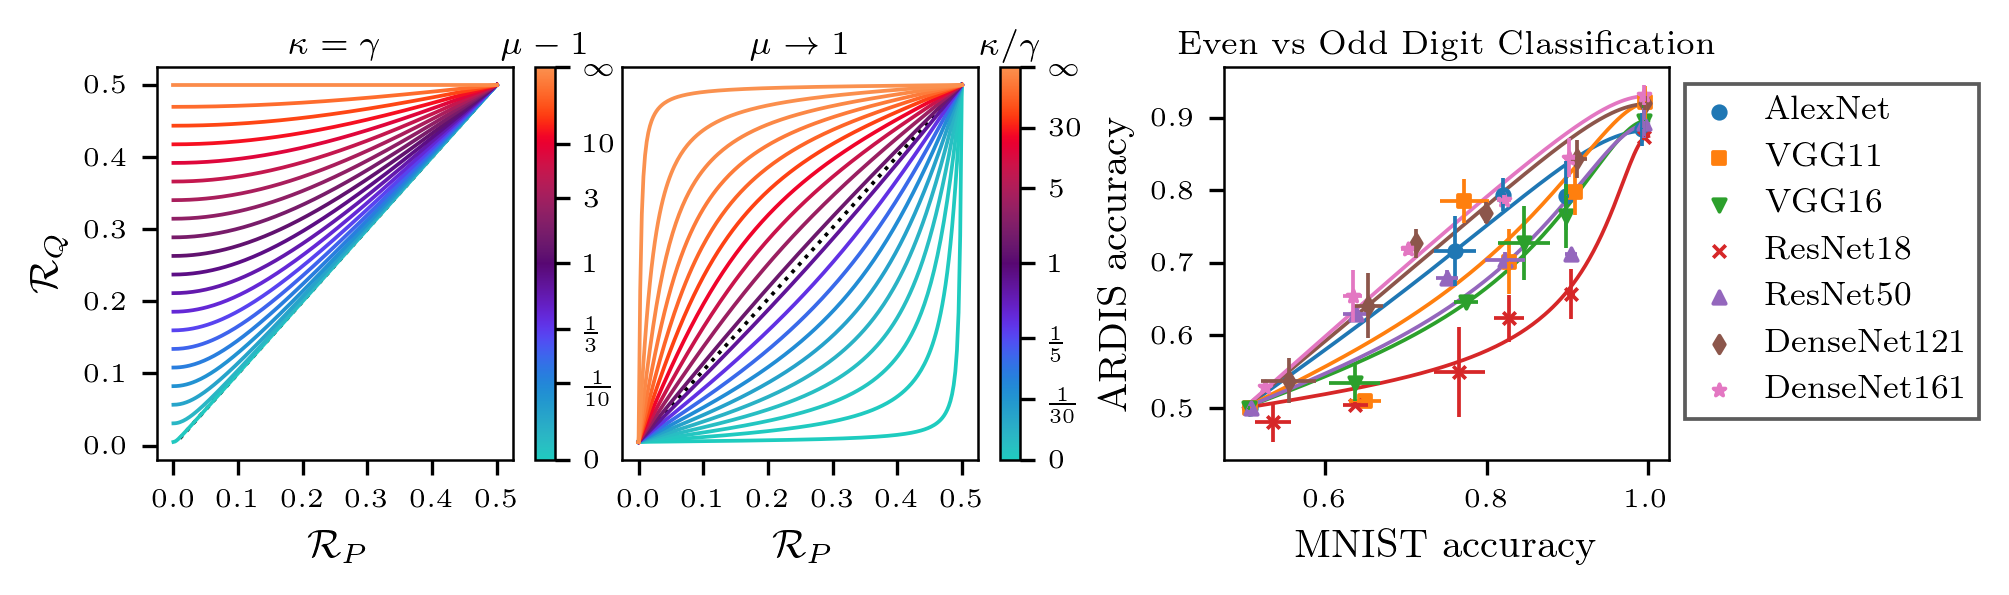

In [8]:
plot_names = {
    'alexnet': 'AlexNet',
    'vgg11': 'VGG11',
    'vgg16': 'VGG16',
    'resnet18': 'ResNet18',
    'resnet50': 'ResNet50',
    'densenet121': 'DenseNet121',
    'densenet161': 'DenseNet161'
}

kQ_kRs_interp = np.asarray([x ** 2 / (1 - x **2) for x in np.linspace(EPSILON, 1 - EPSILON, 500)])
limiting_risks_interp = np.asarray([get_R_Q(1 + kQ_kR, 1)[0] for kQ_kR in kQ_kRs_interp])

def kQ_kR_scale_fun(x):
    return np.interp(x, 2 * limiting_risks_interp, kQ_kRs_interp)

def kQ_kR_scale_fun_inv(y):
    return np.interp(y, kQ_kRs_interp, 2 * limiting_risks_interp)

kQ_kRs_lin = np.linspace(1e-2, 1 - 1e-2, 20)
kQ_kRs = [kQ_kR_scale_fun(x) for x in kQ_kRs_lin]
kappa_gamma = 1

cmap = cmasher.guppy_r
sm = cm.ScalarMappable(cmap=cmap)
    
################

fig, axes = plt.subplots(1, 3, figsize=(6.5, 1.7), dpi=300)

ax = axes[0]

ax.plot([1e-2, 0.5], [1e-2, 0.5], ':k')

for kQ_kR in kQ_kRs:
    R_Q = get_R_Q(1 + kQ_kR, kappa_gamma)
    ax.plot(R_P, R_Q, color=cmap(kQ_kR_scale_fun_inv(kQ_kR)))
    
ax.set_title(r'$\kappa = \gamma$')
cbar = fig.colorbar(sm, ax=ax, ticks=[kQ_kR_scale_fun_inv(x) for x in [0, 1/10, 1/3, 1, 3, 10]] + [1])
cbar.ax.set_yticklabels([0, r'$\frac{1}{10}$', r'$\frac{1}{3}$', 1, 3, 10, r'$\infty$'])
cbar.ax.set_title(r'$\mu - 1$')

ax.set_xticks(np.arange(6) / 10)
ax.set_yticks(np.arange(6) / 10)
ax.set_xlabel('$\mathcal{R}_P$')
ax.set_ylabel('$\mathcal{R}_Q$')

####################################################

def kappa_gamma_scale_fun(x):
    return x / (1 - x)

def kappa_gamma_scale_fun_inv(y):
    return 1 - 1 / (1 + y)

kappa_gammas_lin = np.linspace(0.01, 0.99, 20)
kappa_gammas = [kappa_gamma_scale_fun(x) ** 2 for x in kappa_gammas_lin]
kQ_kR = EPSILON

################

ax = axes[1]
ax.plot([1e-2, 0.5], [1e-2, 0.5], ':k')

for kappa_gamma in kappa_gammas:
    R_Q = get_R_Q(1 + kQ_kR, kappa_gamma)
    ax.plot(R_P, R_Q, color=cmap(kappa_gamma_scale_fun_inv(kappa_gamma)))
    
ax.set_title(r'$\mu \to 1$')
cbar = fig.colorbar(sm, ax=ax, ticks=[kappa_gamma_scale_fun_inv(np.sqrt(x)) for x in [0, 1/30, 1/5, 1, 5, 30]] + [1])
cbar.ax.set_yticklabels([0, r'$\frac{1}{30}$', r'$\frac{1}{5}$', 1, 5, 30, r'$\infty$'])
cbar.ax.set_title(r'$\kappa/\gamma$')

ax.set_xticks(np.arange(6) / 10)
ax.set_yticks(np.arange(6) / 10)
ax.set_yticks([])
ax.set_xlabel('$\mathcal{R}_P$')

# custom positioning
shift_amount = 0.035
l, r, w, h = ax.get_position().bounds
ax.set_position((l - shift_amount, r, w, h), 'both')
l, r, w, h = cbar.ax.get_position().bounds
cbar.ax.set_position((l - shift_amount, r, w, h), 'both')

####################################################

ax = axes[2]

markers = ['o', 's', 'v', 'x', '^', 'd', '*']

for i, (name, color, marker) in enumerate(zip(plot_names, color_cycle, markers)):
    
    mnist_acc, ardis_acc = get_sequence_accuracies(name)
    ax.scatter(mnist_acc, ardis_acc, color=color, label=plot_names[name], marker=marker)
    
    mnist_std, ardis_std = get_sequence_stds(name)
    ax.errorbar(mnist_acc, ardis_acc, yerr=ardis_std, xerr=mnist_std, fmt=',', color=color)

    kQ_kR, kappa_gamma = fit_params[name]
    R_Q = get_R_Q(kQ_kR, kappa_gamma)
    ax.plot(1 - R_P, 1 - R_Q, color=color, zorder=-1)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Even vs Odd Digit Classification')
ax.set_xlabel('MNIST accuracy')
ax.set_ylabel('ARDIS accuracy')

#plt.tight_layout()

plt.savefig('classification_risk_shifts.pdf', bbox_inches='tight')
plt.show()

In [9]:
def squared_error(z1, z2):
    return np.mean((z1 - z2) ** 2)

def zero_one_loss(z1, z2):
    return np.mean((z1 * z2 < 0).astype(float))

def log_loss(z1, z2):
    return np.mean(np.log(1 + np.exp(-np.sign(z1) * z2)))

def hinge_loss(z1, z2):
    return np.mean(np.maximum(1 - np.sign(z1) * z2, 0))

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.14it/s]


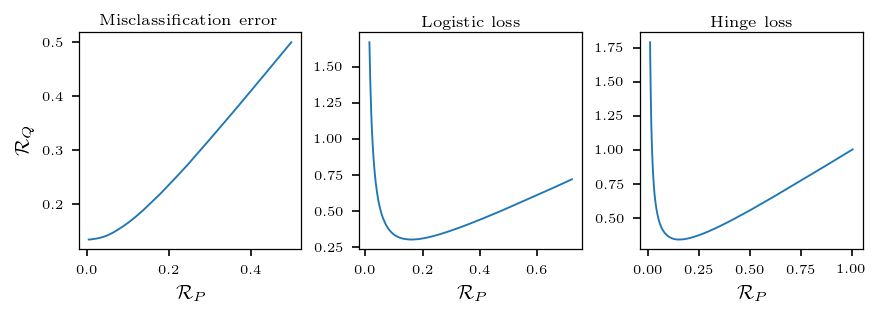

In [10]:
sigma_beta = 1
gamma = 1
kappa = 1
rP = 0.9
mu = 1.2

n = 10 ** 6
b = 1
c = 1

OmegaP = rP * sigma_beta ** 2
GammaP = rP * sigma_beta ** 2 / (1 + b)
LambdaP = rP * sigma_beta ** 2 / (1 + b) ** 2
ThetaP = rP / (1 + b) ** 2

OmegaQ = gamma * mu * OmegaP
GammaQ = gamma * GammaP
LambdaQ = gamma * LambdaP
ThetaQ = kappa * ThetaP

def get_covs(a):
    
    CovP = np.asarray([
        [OmegaP, a * GammaP],
        [a * GammaP, a ** 2 * LambdaP + c * ThetaP]
    ])
    
    CovQ = np.asarray([
        [OmegaQ, a * GammaQ],
        [a * GammaQ, a ** 2 * LambdaQ + c * ThetaQ]
    ])
    
    return CovP, CovQ

def sqrtm(A):
    w, V = np.linalg.eigh(A)
    return V @ (np.sqrt(w)[:, None] * V.T)

W = np.random.randn(2, n)
a_list = np.logspace(-3, 2, 200)

losses = [zero_one_loss, log_loss, hinge_loss]
loss_names = ['Misclassification error', 'Logistic loss', 'Hinge loss']

plt.figure(dpi=150)

for k, (ell, name) in enumerate(zip(losses, loss_names)):
    
    plt.subplot(1, len(losses), k + 1)

    error_d1 = np.zeros(len(a_list))
    error_d2 = np.zeros(len(a_list))

    for i, a in enumerate(tqdm(a_list)):
        CovP, CovQ = get_covs(a)
        
        Z_star, Z_hat = sqrtm(CovP) @ W
        error_d1[i] = ell(Z_star, Z_hat)
        
        Z_star, Z_hat = sqrtm(CovQ) @ W
        error_d2[i] = ell(Z_star, Z_hat)

    plt.plot(error_d1, error_d2)
    plt.title(name)
    plt.xlabel('$\mathcal{R}_P$')
    if k == 0:
        plt.ylabel('$\mathcal{R}_Q$')

plt.tight_layout()
plt.savefig('logistic_hinge_losses.pdf', bbox_inches='tight')
plt.show()